Removed First row from the PPG-BP dataset xlsx file
Converted new xlsx to CSV for faster execution
New CSV file named as SubjectData.csv
PPGBPDatabase folder contains all the ppg cycle of the subjects in TXT format

In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
# from scipy.stats import skew


## Importing SubjectData CSV file using Pandas

In [2]:
SubjectData=pd.read_csv('SubjectData.csv')
SubjectData.head()

,Num.,subject_ID,Sex(M/F),Age(year),Height(cm),Weight(kg),Systolic Blood Pressure(mmHg),Diastolic Blood Pressure(mmHg),Heart Rate(b/m),BMI(kg/m^2),Hypertension,Diabetes,cerebral infarction,cerebrovascular disease
0,1,2,Female,45,152,63,161,89,97,27.27,Stage 2 hypertension,NaN,NaN,NaN
1,2,3,Female,50,157,50,160,93,76,20.28,Stage 2 hypertension,NaN,NaN,NaN
2,3,6,Female,47,150,47,101,71,79,20.89,Normal,NaN,NaN,NaN
3,4,8,Male,45,172,65,136,93,87,21.97,Prehypertension,NaN,NaN,NaN
4,5,9,Female,46,155,65,123,73,73,27.06,Prehypertension,NaN,NaN,NaN


### Data Cleaning
Label encoding - converting the labels into numerical format <br>
Such as <br>
Encoding NaN with 0 in Cerebral Infarction and 'cerebral infarction' as 1 <br>
0 = No Cerebral Infarction <br>
1 = Cerebral Infarction

In [3]:
from sklearn import preprocessing
label_encoder = preprocessing.LabelEncoder()
# SubjectData['cerebral infarction']= label_encoder.fit_transform(SubjectData['cerebral infarction'])
SubjectData['Hypertension']= label_encoder.fit_transform(SubjectData['Hypertension'])
SubjectData['Diabetes']= label_encoder.fit_transform(SubjectData['Diabetes'])
SubjectData['cerebrovascular disease']= label_encoder.fit_transform(SubjectData['cerebrovascular disease'])
SubjectData['Sex(M/F)']= label_encoder.fit_transform(SubjectData['Sex(M/F)'])
SubjectData.head()
#SubjectData['cerebral infarction'].unique()

# ExplicitEncodingMapForCI
ExplicitEncodingMapForCI={'cerebral infarction':1,' ':0}
SubjectData['cerebral infarction']=SubjectData['cerebral infarction'].replace(np.nan,' ')
SubjectData['cerebral infarction']=SubjectData['cerebral infarction'].map(ExplicitEncodingMapForCI)





In [4]:
countCI=SubjectData['cerebral infarction'].value_counts()
print('Total number of subjects :',countCI[1]+countCI[0])
print('Total number of subjects with CI:',countCI[1])
print('Total number of subjects without CI:',countCI[0])

Total number of subjects : 219
Total number of subjects with CI: 20
Total number of subjects without CI: 199


### Importing PPG Cycle of the Target Patients in a dictionary


In [5]:
baseurl='PPGBPDatabase/'
PPGCycle={}
for i in range(420):
    try:
        temp=[]
        for j in range(1,4):
            f=open(baseurl+f'{i}_{j}.txt','r')
            data=f.readline()
            data=data.split('\t')
            data=data[0:-1]
            data=list(map(int,list(map(float,data))))
            f.close()
            temp.append(data)  
        PPGCycle[str(i)]=temp
    except:
        continue


## Sample Ploting of PPG Cycle of Subject 2

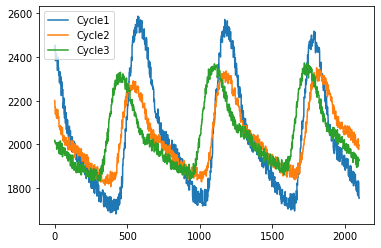

In [6]:
C1=PPGCycle['2'][0]
C2=PPGCycle['2'][1]
C3=PPGCycle['2'][2]
plt.plot(C1,label='Cycle1')
plt.plot(C2,label='Cycle2')
plt.plot(C3,label='Cycle3')
plt.legend(['Cycle1','Cycle2','Cycle3'])
plt.show()

### Extracting Infromation from the PPGCycle

# Functions to calculate Featues and other values

In [7]:
def Kurt(x):
    size=len(x)
    deviationSq=[]
    deviationSq4=[]
    mean=sum(x)/size
    for i in x:
        deviationSq.append((i-mean)**2)
        deviationSq4.append((i-mean)**4)
    SecondMoment=sum(deviationSq)/size
    FourthMoment=sum(deviationSq4)/size
    Kurtosis=FourthMoment/(SecondMoment**2)
    return Kurtosis

def maxminslope(x):
    max=-math.inf
    min=math.inf
    size=len(x)
    for i in range(size-1):
        if x[i+1]-x[i]>max:
            max=x[i+1]-x[i]
        if x[i+1]-x[i]<min:
            min=x[i+1]-x[i]
    return max,min
    
def Conf(act,pred):
    size=len(act)
    act=list(map(int,act))
    pred=list(map(int,pred))
    # print(act)
    # print(pred)
    TN=0
    FP=0
    FN=0
    TP=0
    for i in range(size):
        if(act[i]==0 and pred[i]==0):
            TN+=1
        elif(act[i]==0 and pred[i]==1):
            FP+=1
        elif(act[i]==1 and pred[i]==0):
            FN+=1
        elif(act[i]==1 and pred[i]==1):
            TP+=1

    print('TN:',TN)
    print('FP:',FP)
    print('FN:',FN)
    print('TP:',TP)
    # print('Accuracy:',(TP+TN)/size)
    print('Precision:',TP/(TP+FP))
    print('Recall:',TP/(TP+FN))
    print('F1 Score:',2*TP/(2*TP+FP+FN))
    return [[TN,FP],[FN,TP]]
        
def Skewness(x):
    size=len(x)
    mean=sum(x)/size
    deviation=[]
    deviationSq=[]
    StandardDeviation=0
    for i in x:
        deviation.append((i-mean))
        deviationSq.append((i-mean)**2)
        StandardDeviation+=(i-mean)**2

    StandardDeviation=(StandardDeviation/size)**0.5
    Skewness=0
    for i in deviation:
        Skewness+=(i/StandardDeviation)**3
    Skewness=Skewness*size/(size-1)/(size-2)
    return Skewness

# Signal to noise ratio calculation
def SNR(PPG):
    mean=np.mean(PPG)
    std=np.std(PPG)
    snr=mean/std
    return snr


### Signal to noise ratio Testing


In [8]:

def checkexist(id):
    return not (SubjectData.loc[(SubjectData['cerebral infarction']==1) & (SubjectData['subject_ID']==id)]).empty

moreCIdata={}
for i in PPGCycle.keys():
    data=SubjectData.loc[(SubjectData['subject_ID']==int(i))]
    if(checkexist(int(i))):
        print(i)
    snr1=PPGCycle[i][0]
    snr2=PPGCycle[i][1]
    snr3=PPGCycle[i][2]
    if(snr1 >= snr2 and snr1 >= snr3):
        PPGCycle[i]=PPGCycle[i][0]
    elif(snr2 >= snr1 and snr2 >= snr3):
        PPGCycle[i]=PPGCycle[i][1]
    else:
        PPGCycle[i]=PPGCycle[i][2]

32
84
85
86
87
88
97
99
100
103
104
106
134
135
136
139
140
148
149
155


In [9]:
print(SubjectData.loc[(SubjectData['cerebral infarction']==1)])

     Num.  subject_ID  Sex(M/F)  Age(year)  Height(cm)  Weight(kg)  \
25     26          32         1         44         170          65   
53     54          84         0         76         150          50   
54     55          85         0         58         164          53   
55     56          86         0         71         159          80   
56     57          87         0         78         160          55   
57     58          88         0         77         153          60   
65     66          97         1         76         168          75   
67     68          99         1         78         170          60   
68     69         100         0         68         150          63   
69     70         103         0         63         153          45   
70     71         104         0         67         155          55   
72     73         106         1         59         171          80   
93     94         134         0         72         157          39   
94     95         13

In [10]:
CMean=[]
CKurtosis=[]
CSkewness=[]
CMaxSlope=[]
CMinSlope=[]
for i in PPGCycle.keys():
    CMean.append(np.mean(PPGCycle[i]))
    CKurtosis.append(Kurt(PPGCycle[i]))
    CSkewness.append(Skewness(PPGCycle[i]))
    CMaxSlope.append(maxminslope(PPGCycle[i])[0])
    CMinSlope.append(maxminslope(PPGCycle[i])[1])
    

### Inserting Extracted Data into the SubjectData

In [11]:
SubjectData['C-Mean']=CMean
SubjectData['C-Kurtosis']=CKurtosis
SubjectData['C-Skewness']=CSkewness
SubjectData['C-MaxSlope']=CMaxSlope
SubjectData['C-MinSlope']=CMinSlope
#Min Max Kurtosis and Skewness Mean
#Max slope of the line


### Plotting Heat Map

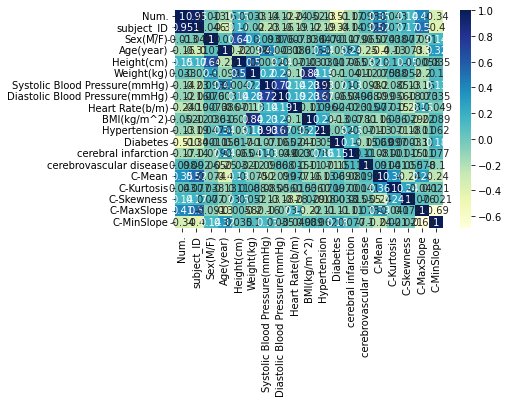

In [12]:
dataplot=sns.heatmap(SubjectData.corr(), cmap="YlGnBu", annot=True)
plt.show()

### Create Training and Test Sets

In [13]:
from sklearn.model_selection import train_test_split
# X = SubjectData.iloc[:, :-1]
X = SubjectData.drop([
    'subject_ID',
    'cerebral infarction'],
    axis=1)
y = SubjectData['cerebral infarction']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, random_state=0)

In [14]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
print('Using OverSampling to balance the dataset SMOTE: ')
print(f'Original dataset with cerebral infarction : {sum(y_train==1)}')
print(f'Original dataset without cerebral infarction : {sum(y_train==0)}')

smote = SMOTE(random_state = 2)
nearMiss = NearMiss()

X_train_over, y_train_over = smote.fit_resample(X_train, y_train.ravel())
X_train_miss, y_train_miss = nearMiss.fit_resample(X_train, y_train.ravel())

print(f'Over sampled dataset with cerebral infarction : {sum(y_train_over==1)}')
print(f'Over sampled dataset without cerebral infarction : {sum(y_train_over==0)}')
print()
print(f'Under sampled dataset with cerebral infarction : {sum(y_train_miss==1)}')
print(f'Under sampled dataset without cerebral infarction : {sum(y_train_miss==0)}')

Using OverSampling to balance the dataset SMOTE: 
Original dataset with cerebral infarction : 20
Original dataset without cerebral infarction : 188
Over sampled dataset with cerebral infarction : 188
Over sampled dataset without cerebral infarction : 188

Under sampled dataset with cerebral infarction : 20
Under sampled dataset without cerebral infarction : 20


## Building Models

### Logistic Regression

In [15]:
from sklearn.linear_model import LogisticRegression
LogRegNormal = LogisticRegression()
LogRegOver = LogisticRegression()
LogRegUnder = LogisticRegression()
LogRegNormal.fit(X_train, y_train)
LogRegOver.fit(X_train_over, y_train_over)
LogRegUnder.fit(X_train_miss, y_train_miss)
print(f'Accuracy of Logistic regression classifier on training set: {LogRegNormal.score(X_train, y_train):.2f}')
print(f'Accuracy of Logistic regression classifier on test set: {LogRegNormal.score(X_test, y_test):.2f}')

print(f'Accuracy of Logistic regression classifier on over sampled training set: {LogRegOver.score(X_train_over, y_train_over):.2f}')
print(f'Accuracy of Logistic regression classifier on over sampled test set: {LogRegOver.score(X_test, y_test):.2f}')

print(f'Accuracy of Logistic regression classifier on under sampled training set: {LogRegUnder.score(X_train_miss, y_train_miss):.2f}')
print(f'Accuracy of Logistic regression classifier on under sampled test set: {LogRegUnder.score(X_test, y_test):.2f}')

Accuracy of Logistic regression classifier on training set: 0.89
Accuracy of Logistic regression classifier on test set: 1.00
Accuracy of Logistic regression classifier on over sampled training set: 0.81
Accuracy of Logistic regression classifier on over sampled test set: 0.73
Accuracy of Logistic regression classifier on under sampled training set: 0.78
Accuracy of Logistic regression classifier on under sampled test set: 0.36


c:\Users\Anand\Desktop\PPGBPDatabase\New\ppg\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\Anand\Desktop\PPGBPDatabase\New\ppg\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_

### Decision Tree

In [16]:
from sklearn.tree import DecisionTreeClassifier
DTNormal = DecisionTreeClassifier().fit(X_train, y_train)
DTOver = DecisionTreeClassifier().fit(X_train_over, y_train_over)
DTUnder = DecisionTreeClassifier().fit(X_train_miss, y_train_miss)
print(f'Accuracy of Decision Tree classifier on training set: {DTNormal.score(X_train, y_train):.2f}')
print(f'Accuracy of Decision Tree classifier on test set: {DTNormal.score(X_test, y_test):.2f}')

print(f'Accuracy of Decision Tree classifier on over sampled training set: {DTOver.score(X_train_over, y_train_over):.2f}')
print(f'Accuracy of Decision Tree classifier on over sampled test set: {DTOver.score(X_test, y_test):.2f}')

print(f'Accuracy of Decision Tree classifier on under sampled training set: {DTUnder.score(X_train_miss, y_train_miss):.2f}')
print(f'Accuracy of Decision Tree classifier on under sampled test set: {DTUnder.score(X_test, y_test):.2f}')

Accuracy of Decision Tree classifier on training set: 1.00
Accuracy of Decision Tree classifier on test set: 0.82
Accuracy of Decision Tree classifier on over sampled training set: 1.00
Accuracy of Decision Tree classifier on over sampled test set: 0.91
Accuracy of Decision Tree classifier on under sampled training set: 1.00
Accuracy of Decision Tree classifier on under sampled test set: 0.09


In [17]:
y_pred = DTNormal.predict(X_test)

# cm=Conf(y_test,y_pred)
# print(cm)

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
print(cm)

[[9 2]
 [0 0]]
